In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1"

In [2]:
import random
import numpy as np
from tqdm import tqdm
import pandas as pd
from scipy import ndimage
from scipy.ndimage import zoom
import gc
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import torch
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torch.backends.cudnn as cudnn
import types
from scipy.stats import pearsonr, spearmanr
import torchio as tio
from datetime import datetime
import wandb
from models.mlpmixer import *

In [3]:
RANDOM_SEED = 551

In [4]:
# control randomness
def set_seed(random_seed=551):
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(random_seed)

In [5]:
def load_data(img_dir, label_dir, label_name, std=False, norm=True):
    df = pd.read_csv(label_dir, index_col=0)[label_name]
    filenames = df.index
    images = []
    for i, index in enumerate(filenames):
        file_name = img_dir + index + '.npy'
        img = np.load(file_name)
        x, y, z = img.shape
        if norm:
            img = (img - img.min()) / (img.max() - img.min())
        if std:
            m = np.mean(img)
            s = np.std(img)
            img = (img - m) / s
        img = img.reshape((1, x, y, z))
        images.append(img)
    return images, df

In [6]:
# augmentation
def get_augmentation_transform():
    random_rotate = tio.RandomAffine(scales=(1.0, 1.0),
                                     degrees=12,)
    random_flip = tio.RandomFlip(axes='LR',
                                 flip_probability=0.5)
    random_shift = tio.RandomAffine(scales=(1.0, 1.0),
                                    degrees=0,
                                    translation=(20,20,20))
    compose = tio.transforms.Compose([random_rotate, random_flip, random_shift])
    augment = tio.transforms.OneOf([random_rotate, random_flip, random_shift, compose])
    return augment

In [7]:
class NeckDataset(Dataset):
    def __init__(self, X=None, y=None, transform=None, lds=False, lds_kernel='gaussian', lds_ks=5, lds_sigma=2):
        self.X = X
        self.y = y.values
        self.transform = transform
        
    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, idx):
        image = self.X[idx]
        label = np.array([self.y[idx]]).astype('float16')
        if self.transform is not None:
            image = self.transform(image)
        return [image, label]

In [8]:
def train(model, train_loader, optimizer):
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.train()
    for inputs, labels in tqdm(train_loader):              
        inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
        
        # feedforward
        outputs = model(inputs)
        
        pred = outputs.detach().cpu().numpy()
        truth = labels.detach().cpu().numpy()
        preds = np.append(preds, pred.reshape(pred.size), axis=0)
        truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
        # calculate loss
        mse = criterion1(outputs, labels)
        mae = criterion2(outputs, labels)
        
        # gradient initialization
        optimizer.zero_grad()
        # backpropagation
        mse.backward()
        # weight update
        optimizer.step()
        
        total_mae += mae.data.item()
        total_mse += mse.data.item()
        
        gc.collect()
        torch.cuda.empty_cache()
    return preds, truths, total_mse, total_mae

In [9]:
def valid(model, valid_loader):    
    total_mae, total_mse = 0, 0
    preds, truths = np.array([]), np.array([])
    
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(valid_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)

            outputs = model(inputs)
            
            pred = outputs.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)

            mse = criterion1(outputs, labels)
            mae = criterion2(outputs, labels)
            
            total_mae += mae.data.item()
            total_mse += mse.data.item()
        
    return preds, truths, total_mse, total_mae

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Device:', device)
print('Current cuda device:', torch.cuda.current_device())
print('Count of using GPUs:', torch.cuda.device_count())

Device: cuda
Current cuda device: 0
Count of using GPUs: 2


In [11]:
label_name = 'FL_WMH_VOL_icv'
# label_name = 'FL_WMH_VOL_mL'
# label_name = 'WMH_GRADE'
# label_name = 'Cortical Gray Matter Total Percent Of Icv'
# label_name = 'FL_PVWMH_VOL_icv'
# label_name = 'FL_DWMH_VOL_icv'
img_dir = 'img_npy/'
label_dir = 'labels/data_975.csv'

In [12]:
# 이번 실험 고정 값
batch_size = 16
test_batch_size = 32
k = 5

In [13]:
# load data
X, y = load_data(img_dir, label_dir, label_name, std=True, norm=True)

# initialize seed
set_seed()

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# train set
train_set = NeckDataset(X_train, y_train)

# test set & loader
test_set = NeckDataset(X_test, y_test)
test_loader = DataLoader(test_set, batch_size=batch_size, num_workers=16)

len(X_train), len(X_test), len(y_train), len(y_test)

(780, 195, 780, 195)

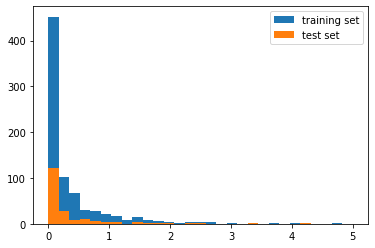

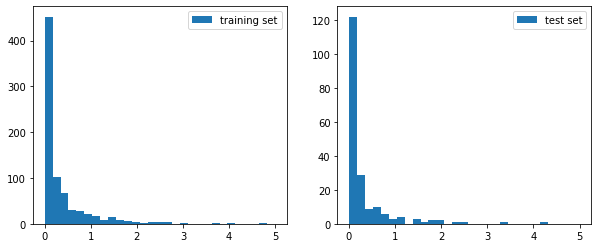

In [14]:
bins = np.linspace(0, 5, 30)

plt.hist(y_train, bins, label='training set')
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')
plt.show()
plt.close()


plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(y_train, bins, label='training set')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.hist(y_test, bins, label='test set')
plt.legend(loc='upper right')

plt.show()
plt.close()

---

### 5-Fold Cross Validation Section

In [15]:
# 바꿀 값
epochs = 50
weight_decay = 0.1
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.45

In [16]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


train_mae,██▇▇▆▇▅▆▅▅▅▅▄▅▃▄▅▄▃▃▄▄▂▃▃▃▃▃▃▂▂▂▁▂▂▂▁▁▂▁
train_mse,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▂▁▁▁▁▁
train_pearson,▁▂▃▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇█▇▇▇█▇██████
train_spearman,▁▁▃▂▃▃▅▅▅▅▅▆▆▆▇▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇████▇█████
valid_mae,▃▆▄▄▃▂▆▂▅▁▂▃▄▂▆▃▂▃▂▂▄▁▆▂▅▄▂▁▂▅▄▂▅▃▅▂▅█▄▃
valid_mse,▃▄▂▂▂▂▃▁▂▂▁▁▂▁▃▂▁▂▂▂▃▄▄▃▃▃▃▃▃▅▅▃▄▄▅▄▅█▅▆
valid_pearson,▁▃▅▆▇▇▇▇▇█████████████████████████▇▇▇▇▇▇
valid_spearman,▁▃▄▅▆▆▆▇▇▇▇▇▇▇▇█████▇█▇▇▇▇███▇▇█████████
train_mae,0.3245
train_mse,0.25357
train_pearson,0.52339


Fold 2


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


train_mae,██▇▇▅▆▆▆▆▅▅▅▅▅▄▅▄▅▃▄▄▃▃▃▃▂▄▂▃▃▂▃▂▃▂▂▂▂▂▁
train_mse,█▇▇▆▅▆▆▅▅▄▄▅▅▄▄▄▃▃▃▃▃▂▂▃▂▂▂▂▃▂▂▂▂▂▂▂▁▁▁▁
train_pearson,▁▁▁▂▄▃▃▄▄▄▅▄▄▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_spearman,▁▁▁▂▃▃▃▄▄▄▅▄▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
valid_mae,▆█▆▆▇▅▅▆▄▄▃▅▅▆█▅▃▁▄▃▃▄▃▄▂▄▁▂▂▂▇▃▃▂▃▄▃▃▂▅
valid_mse,█▅▆▄▄▆▃▃▂▃▃▃▂▂▂▂▂▃▂▁▂▃▂▃▂▂▂▂▂▂▁▁▂▁▂▁▂▃▂▁
valid_pearson,▁▂▅▆▇▇▇▇████████████████████████████████
valid_spearman,▁▂▅▆▇▇▇▇▇▇██████████████████████████████
train_mae,0.30145
train_mse,0.22666
train_pearson,0.45429


Fold 3


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.67it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


train_mae,▇█▇▆▆▅▅▅▅▄▆▄▄▃▃▄▃▃▃▄▃▃▃▃▃▂▂▃▂▁▂▂▁▁▁▁▂▂▁▁
train_mse,██▆▆▅▅▅▅▅▄▅▄▄▃▃▄▃▃▃▃▃▃▃▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁
train_pearson,▂▁▃▃▅▅▅▅▄▆▅▅▆▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇██▇▇████████
train_spearman,▁▁▂▃▄▄▄▅▄▆▅▆▆▆▆▆▇▇▇▆▇▇▆▇▇▇▇▇█▇▇▇████████
valid_mae,▃▅▆▆▃▂▇▇▇▆▁▃▃▆█▄▄▂▅▅▁▂▆▆▅▃▂▄▃▆█▆▁▅▆▂▅▅▃▆
valid_mse,▇▆█▆▆▃▄▆▅▃▃▃▂▅▅▃▂▂▃▂▂▂▂▃▂▂▂▂▂▃▄▃▁▃▃▅▂▄▁▃
valid_pearson,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
valid_spearman,▁▄▅▆▇▇▇▇▇▇▇▇▇▇██████████████████████████
train_mae,0.33008
train_mse,0.25942
train_pearson,0.46067


Fold 4


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


train_mae,▇█▇▆▆▅▆▅▅▅▅▄▅▄▅▃▃▄▃▄▃▂▃▃▃▃▃▂▂▂▂▂▁▂▂▂▁▁▂▂
train_mse,█▇▆▆▆▄▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
train_pearson,▁▁▃▃▃▅▃▅▄▅▅▅▅▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇█▇█▇████
train_spearman,▁▁▂▃▃▄▄▄▅▅▅▆▆▆▆▆▆▆▆▆▇▆▇▆▇▇▇▇▇▇▇▇█▇▇██▇▇▇
valid_mae,▆▅▆█▅▄▃▅▅▃▃▄▄▄▂▃▄▃▃▂▂▄▄▂▂▂▂▂▂▂▃▂▃▂▃▁▂▁▁▃
valid_mse,█▇▆▇▄▄▄▄▃▄▄▂▃▃▄▂▂▃▃▃▄▁▃▂▂▂▃▃▂▃▁▂▃▁▃▃▁▂▂▁
valid_pearson,▁▄▆▆▇███████████████████████████████████
valid_spearman,▁▄▅▆▇▇▇▇▇▇▇▇████████████████████████████
train_mae,0.32409
train_mse,0.24626
train_pearson,0.44599


Fold 5


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.89it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.88it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


train_mae,▇██▆▆▆▅▆▅▆▄▅▄▄▄▄▄▄▃▃▃▃▃▃▃▂▃▃▂▂▃▂▂▂▁▂▁▂▁▁
train_mse,██▇▆▆▆▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▂▂▁▁▁▁▁
train_pearson,▁▁▂▂▃▃▄▄▄▄▆▆▅▆▅▆▆▇▇▆▆▇▇▇▆▇▇▇█▇▇▇█▇▇█████
train_spearman,▁▁▁▃▃▃▅▅▅▅▆▆▆▆▆▇▆▇▇▆▇▇▇▇▇█▇▇█▇▇█▇▇██▇███
valid_mae,█▆▄▇▄▄▄▄▆▃▆▂▅▂▃▃▄▃▄▆▄▅▃▆▄▅▃▂▁▃▂▂▅▅▃▁▄▂▂▂
valid_mse,█▅▄▅▃▃▃▂▄▄▃▂▂▁▁▂▂▃▂▄▃▂▂▃▂▂▁▂▂▃▁▁▂▂▂▁▂▁▂▁
valid_pearson,▁▃▅▅▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
valid_spearman,▁▄▆▆▇▇▇▇▇▇▇█████████████████████████████
train_mae,0.33469
train_mse,0.26535
train_pearson,0.49169


In [17]:
# 바꿀 값
epochs = 100
weight_decay = 0.1
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.3

In [18]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.67it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.77it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.72it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


train_mae,██▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▄▄▄▄▄▄▃▄▄▃▃▂▃▂▂▂▂▂▂▁▁
train_mse,█▇▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▁▁▁▁
train_pearson,▁▂▃▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████
train_spearman,▁▂▃▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█████
valid_mae,▂▃▂▃▃▂▃▃▁▁▂▃▃▁▁▂▃▂▃▂▃▃▃▃▅▆▄▄▄▅█▄▅▇▃▄▃▄▄▅
valid_mse,▂▁▁▂▂▁▁▂▁▁▂▂▂▂▂▂▂▂▂▃▃▃▃▃▅▅▄▄▄▅█▅▅█▅▆▆▆▇▇
valid_pearson,▁▅▇▇▇███████████▇▇▇▇▇▇▆▆▆▅▆▅▅▅▄▅▄▄▅▄▄▄▄▄
valid_spearman,▁▄▆▆▇▇▇▇██▇▇▇█████████████████▇██▇████▇▇
train_mae,0.25559
train_mse,0.13862
train_pearson,0.79103


Fold 2


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 4 / 100


  5%|██▎                                         | 2/39 [00:02<00:50,  1.35s/it]


KeyboardInterrupt: 

In [19]:
# 바꿀 값
epochs = 75
weight_decay = 0.1
lr = 1e-03
optim_class = optim.Adam
dropout_rate = 0.5

In [20]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


train_mae,▄█▁
train_mse,█▅▁
train_pearson,▂▁█
train_spearman,▁██
valid_mae,▁█▃
valid_mse,█▁▃
valid_pearson,▁▄█
valid_spearman,▁▄█
train_mae,0.35127
train_mse,0.28982
train_pearson,0.01654


# Epoch 1 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 2 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 3 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 4 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 5 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 6 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 7 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 8 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 9 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 10 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 11 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 12 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 13 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 14 / 75


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 15 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 16 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 17 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 18 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 19 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 20 / 75


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 21 / 75


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 22 / 75


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 23 / 75


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 24 / 75


 38%|████████████████▌                          | 15/39 [00:06<00:10,  2.28it/s]


KeyboardInterrupt: 

In [21]:
# 바꿀 값
epochs = 50
weight_decay = 0.1
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.4

In [22]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


train_mae,█▄▃▄▃▄▃▂▂▂▂▃▃▂▂▂▂▁▂▃▃▁▃
train_mse,█▄▂▂▁▃▂▂▂▂▂▂▂▁▁▁▂▁▂▂▂▁▂
train_pearson,▁▃▇▆█▄▇▆▆▆▆▆▆▇▇▇▅█▆▄▅▇▆
train_spearman,▁▃▅▅▅▂▇▆▄▆▄▅▄▆▆▆▅█▅▄▅▇▄
valid_mae,▂█▆▄▄▅▂▁▃▅▂▁▂▁▁▄▅█▆▃▂▄▂
valid_mse,█▇▅▃▃▄▂▄▂▃▄▃▂▄▁▃▃▅▃▂▁▃▂
valid_pearson,▂▇▄▆▅▇█▅▇▆▃▆▆▁█▄▆▅▇▆▇▅▅
valid_spearman,▄▆▄▄▃▆▇▄█▄▅▅▇▁█▃▅▅▆▆▆▃▇
train_mae,0.36948
train_mse,0.33357
train_pearson,0.17007


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.97it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


train_mae,▇█▇▇▆▆▅▆▅▅▅▅▄▅▃▄▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▁▂▂▂▁▁▂▁
train_mse,█▇▆▆▆▆▅▅▅▅▄▄▄▄▃▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▁▂▁▁▁▁▁▁
train_pearson,▁▁▂▃▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▆▇▇▇▆▇▇█▇▇▇████████
train_spearman,▁▁▂▃▃▃▅▅▆▆▅▆▆▆▇▆▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇█████████
valid_mae,▄▅▄▃▃▂▆▂▄▁▂▃▄▂▅▃▁▃▂▂▃▁▅▂▄▄▂▁▂▄▄▂▄▃▄▂▄█▃▃
valid_mse,▃▄▂▂▂▂▃▁▂▂▁▁▂▁▃▂▁▂▂▂▃▄▄▃▃▃▃▂▃▄▅▃▄▄▅▄▄█▅▅
valid_pearson,▁▃▅▆▇▇▇▇▇█████████████████████████▇▇▇▇▇▇
valid_spearman,▁▃▄▅▆▇▆▇▇▇▇▇▇▇▇███████▇▇▇▇███▇▇█████████
train_mae,0.32283
train_mse,0.25114
train_pearson,0.532


Fold 2


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.67it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


train_mae,▇█▇▆▅▆▆▆▆▄▅▅▄▄▄▅▄▄▃▃▄▃▃▃▃▂▃▂▃▃▂▃▂▂▂▂▂▂▂▁
train_mse,██▇▆▅▅▆▅▅▄▄▄▄▄▄▄▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▂▂▂▁▁▁▁
train_pearson,▁▁▁▃▄▃▃▄▄▅▅▅▅▅▆▆▆▆▆▇▆▇▇▇▇█▇▇▇▇▇▇█▇█▇████
train_spearman,▁▁▁▃▃▃▄▅▄▅▅▄▅▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇▇▇█████
valid_mae,▇█▆▆█▅▆▆▄▄▃▅▆▆█▆▃▁▄▃▂▄▃▄▂▄▁▃▂▂▇▄▃▂▂▄▃▃▃▆
valid_mse,█▅▆▄▄▆▃▃▂▃▃▃▂▂▂▂▂▃▂▁▂▃▂▃▂▂▂▂▂▂▁▁▂▂▂▁▂▃▂▁
valid_pearson,▁▃▅▆▇▇▇▇████████████████████████████████
valid_spearman,▁▂▄▆▇▇▇▇▇▇▇█████████████████████████████
train_mae,0.30165
train_mse,0.22736
train_pearson,0.45117


Fold 3


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


train_mae,▇█▇▆▆▆▅▅▆▄▅▄▄▃▃▄▃▃▂▄▃▃▃▃▃▂▃▃▂▁▂▂▁▁▁▂▂▂▁▁
train_mse,██▆▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▃▃▃▂▃▂▂▂▂▂▁▂▂▂▂▁▁▂▁▁▁▁
train_pearson,▂▁▃▄▅▅▅▅▅▆▅▆▆▆▆▆▆▇▇▆▇▇▇▇▇█▇▇██▇▇████████
train_spearman,▁▁▂▃▄▄▅▅▄▆▆▆▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇▇████████
valid_mae,▃▄▆▅▃▂█▇▆▆▁▃▃▅█▃▄▂▆▅▁▂▆▆▅▃▃▄▃▆█▆▁▅▅▃▅▅▃▆
valid_mse,▇▆█▆▆▃▅▆▅▃▃▃▂▅▅▃▂▂▃▃▂▂▂▃▂▂▂▂▂▃▄▃▁▃▃▅▂▄▁▃
valid_pearson,▁▃▅▅▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇████████████████████
valid_spearman,▁▄▅▆▇▇▇▇▇▇▇▇▇▇▇█████████████████████████
train_mae,0.32988
train_mse,0.25785
train_pearson,0.46724


Fold 4


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


train_mae,▇█▆▅▆▅▆▄▅▅▄▄▅▄▅▄▃▄▃▄▃▂▃▃▃▃▃▂▂▂▂▃▁▂▂▂▁▂▂▂
train_mse,█▇▆▆▆▄▅▄▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▁▂▁▂▁▁▁▁
train_pearson,▁▁▃▃▃▅▄▅▄▅▅▆▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇███▇████
train_spearman,▁▁▂▃▄▅▄▅▅▅▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇█▇▇██▇▇▇
valid_mae,▆▅▆█▅▄▃▄▅▃▃▄▄▄▁▃▄▃▄▂▂▄▃▂▂▂▂▂▂▂▃▂▃▂▂▁▂▁▁▃
valid_mse,█▇▆▇▄▄▄▄▄▄▄▂▃▃▄▂▂▃▃▃▄▁▃▂▂▂▃▃▂▃▁▂▃▁▄▃▁▂▂▁
valid_pearson,▁▄▅▆▇███████████████████████████████████
valid_spearman,▁▄▅▆▇▇▇▇▇▇▇▇████████████████████████████
train_mae,0.32313
train_mse,0.24524
train_pearson,0.45032


Fold 5


# Epoch 1 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 2 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 3 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 4 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 5 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 6 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 7 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 8 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 9 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 10 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 11 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 12 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 13 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 14 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 15 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 16 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 17 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 18 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.99it/s]


# Epoch 19 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 20 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 21 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 22 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 23 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 24 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 25 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 26 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 27 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 28 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 29 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 30 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 31 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 32 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 33 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 34 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


# Epoch 35 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 36 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 37 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 38 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 39 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 40 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.73it/s]


# Epoch 41 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 42 / 50


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 43 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 44 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 45 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 46 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 47 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 48 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 49 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 50 / 50


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


train_mae,▆██▆▆▆▅▆▅▆▄▅▄▄▄▄▄▄▃▃▃▃▃▂▃▂▃▃▂▂▃▂▂▂▁▂▁▂▁▁
train_mse,██▇▇▆▆▆▆▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▁▁▁▁▁▁
train_pearson,▁▁▂▂▃▄▄▄▄▄▆▆▅▆▅▆▆▆▇▆▆▇▇▇▇▇▇▇█▇▇▇█▇██████
train_spearman,▂▁▁▃▄▄▅▅▅▅▆▆▆▆▆▇▆▆▇▆▇▇▇▇▇█▇▇▇▇▇▇▇▇██████
valid_mae,█▅▄▆▄▄▄▄▅▃▆▂▅▂▃▂▄▂▄▅▃▅▃▆▄▅▃▂▁▃▂▂▄▅▃▁▄▂▂▂
valid_mse,█▅▄▄▃▃▃▂▃▄▃▂▂▁▁▂▂▂▂▄▃▂▂▃▂▂▁▂▂▃▁▁▂▂▂▁▂▁▂▁
valid_pearson,▁▄▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
valid_spearman,▁▄▆▆▇▇▇▇▇█▇█████████████████████████████
train_mae,0.33405
train_mse,0.26447
train_pearson,0.49459


In [23]:
# 바꿀 값
epochs = 100
weight_decay = 0.1
lr = 5e-04
optim_class = optim.SGD
dropout_rate = 0.4

In [24]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


train_mae,▇█▇▆▆▆▆▅▆▅▆▄▅▅▅▄▃▄▄▄▃▃▃▃▃▃▃▃▂▃▂▂▂▂▂▂▁▁▁▁
train_mse,█▇▆▆▆▅▅▄▅▄▄▄▄▄▃▄▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁
train_pearson,▁▂▂▃▃▄▄▅▄▅▆▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇██████
train_spearman,▁▁▂▃▄▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇
valid_mae,▄▄▃▅▄▂▄▃▁▂▃▄▅▁▁▃▃▂▃▂▃▃▃▄▆▆▆▅▄▄█▂▅▄▂▃▄▂▆▅
valid_mse,▄▃▃▄▂▁▂▂▁▁▂▃▃▂▂▂▃▂▂▃▄▃▃▃▆▅▆▄▄▅█▅▅▅▄▅▅▆▇▇
valid_pearson,▁▃▆▆▇▇▇▇███████████████████████████▇▇▇▇▇
valid_spearman,▁▃▅▆▆▇▇▇▇▇▇▇▇█████████▇▇▇▇▇█████████████
train_mae,0.31593
train_mse,0.23938
train_pearson,0.56971


Fold 2


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


train_mae,▇█▆▇▇▆▆▅▅▄▅▅▄▃▅▄▃▃▃▃▄▃▃▃▃▂▂▃▂▂▂▁▂▂▂▁▂▁▁▁
train_mse,█▇▆▆▆▅▅▅▄▅▄▄▃▃▄▃▃▃▃▃▃▃▂▂▃▂▂▂▂▂▂▂▂▂▂▂▁▁▂▁
train_pearson,▂▁▃▂▃▄▃▄▅▅▅▅▆▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇████
train_spearman,▂▁▂▃▃▄▄▅▅▅▅▆▆▆▆▆▆▆▇▆▆▆▇▇▇▇▇▇▇▇▇▇█▇▇███▇█
valid_mae,▇▇█▆▄▃▅▆▃▄▃▃▃▃▂▄▃▄▃▃▃▁▂▂▃▃▅▂▄▃▄▅▂▃▂▂▁▃▁▂
valid_mse,█▇▅▄▄▄▃▃▃▃▃▃▃▂▃▂▂▂▂▂▃▂▂▂▃▃▂▂▂▂▂▂▁▁▁▁▂▂▂▂
valid_pearson,▁▃▅▆▇▇▇▇▇███████████████████████████████
valid_spearman,▁▂▄▆▇▇▇▇▇▇██████████████████████████████
train_mae,0.30373
train_mse,0.22261
train_pearson,0.47496


Fold 3


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


train_mae,▇█▇▇█▇▆▅▅▄▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▃▃▃▃▂▂▂▁▂▁▁
train_mse,█▇▆▅▆▆▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▁▁▁▁
train_pearson,▁▂▃▃▂▃▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇▇█▇██████
train_spearman,▁▂▃▃▃▄▅▅▆▆▆▅▆▆▇▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇████████
valid_mae,▄▇▅▇▅▃▄▆▄▅▂▅▄▃▃▅▂▄▅▄▅▅▄▄▃▆▆▃█▂▅▃▁▅▁▃▂▅▄▄
valid_mse,▇█▆▅▅▃▃▅▃▃▂▃▂▃▂▃▂▅▂▃▄▃▂▃▁▂▃▃▄▂▂▁▁▃▁▃▂▂▂▁
valid_pearson,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
valid_spearman,▁▃▆▆▇▇▇▇▇▇▇▇▇███████████████████████████
train_mae,0.32453
train_mse,0.25013
train_pearson,0.4969


Fold 4


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


train_mae,▇███▇▆▆▇▅▅▅▆▅▅▅▅▃▄▃▃▄▃▄▃▂▃▃▃▃▂▃▂▂▁▂▁▂▁▂▂
train_mse,█▆▇▆▆▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁
train_pearson,▁▂▂▂▂▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇█▇█████
train_spearman,▁▁▂▂▃▄▄▄▅▅▅▅▆▆▆▆▇▇▇▆▆▇▆▆▇▇▇▇▇▇▇▇██████▇█
valid_mae,██▇▅▆▅▅▃▆▅▄▅▄▄▄▄▄▃▄▅▄▄▂▄▄▃▃▂▃▃▃▃▂▄▂▄▂▃▂▁
valid_mse,█▇▆▅▅▅▄▅▃▄▅▄▃▄▃▂▃▃▁▁▂▁▃▁▂▂▁▂▁▃▂▁▂▂▁▂▅▃▂▃
valid_pearson,▁▃▆▇▇███████████████████████████████████
valid_spearman,▁▃▆▇▇▇▇▇▇███████████████████████████████
train_mae,0.31894
train_mse,0.23544
train_pearson,0.49389


Fold 5


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


train_mae,▅█▇▆▆▅▅▅▅▄▅▅▄▄▄▄▃▃▃▃▄▃▃▂▃▃▂▂▃▃▂▂▂▂▂▂▁▁▁▁
train_mse,█▇▇▆▆▅▅▅▅▄▅▄▄▄▃▄▃▃▃▃▃▃▃▂▃▂▃▂▂▂▂▂▂▂▂▂▁▁▁▁
train_pearson,▂▁▂▂▃▄▄▄▅▆▅▅▅▅▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇▇▇▇██████
train_spearman,▃▁▃▄▄▅▅▅▅▆▆▆▆▆▆▆▆▇▇▇▆▇▇▇▇▇▇▇▇▇▇▇▇███████
valid_mae,█▆▄▅▅▆▅▄▄▄▄▃▄▂▂▃▄▃▄▃▃▅▃▄▂▂▃▄▂▂▃▂▃▃▃▁▄▅▅▅
valid_mse,█▆▄▄▄▃▂▂▃▂▄▃▂▂▂▁▂▂▂▁▁▂▂▁▁▂▂▃▁▁▂▁▁▁▁▁▂▃▂▃
valid_pearson,▁▃▅▆▆▇▇▇▇▇▇▇▇▇▇▇▇███████████████████████
valid_spearman,▁▃▆▆▇▇▇▇▇▇██████████████████████████████
train_mae,0.32533
train_mse,0.25982
train_pearson,0.51194


In [25]:
# 바꿀 값
epochs = 100
weight_decay = 0.01
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.4

In [26]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": "MlpMixer-default", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.68it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


train_mae,██▇▇▇▇▇▆▇▆▇▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▃▃▃▃▃▂▃▂▂▁▁▁
train_mse,█▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▃▂▂▂▂▁▁▁▁
train_pearson,▁▂▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██████
train_spearman,▁▂▃▃▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█████
valid_mae,▂▂▂▃▃▂▃▃▁▁▂▃▃▁▁▂▃▂▃▂▂▃▃▃▅▅▄▅▃▄▇▅▅█▄▄▄▄▄▅
valid_mse,▁▁▁▂▁▁▁▂▁▁▁▂▂▁▂▂▂▂▂▂▃▃▃▃▄▄▄▄▄▅▇▅▅█▅▅▆▆▆▆
valid_pearson,▁▅▇▇▇████████████▇▇▇▇▇▆▆▆▆▆▅▅▅▅▅▅▄▅▄▅▅▄▄
valid_spearman,▁▄▆▆▆▇▇▇▇▇▇▇▇█████████████████▇▇▇▇▇▇▇▇▇▇
train_mae,0.19815
train_mse,0.07149
train_pearson,0.89555


Fold 2


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.05it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.00it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.08it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


train_mae,██▇▇▇▇▇▆▇▆▆▆▆▅▆▆▅▅▅▅▅▅▄▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_mse,██▇▇▇▇▇▆▆▆▆▆▆▅▆▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train_pearson,▁▁▃▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_spearman,▁▁▃▃▃▄▄▄▄▅▅▅▅▆▅▆▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇█▇██████
valid_mae,▅▅▅▄▃▃▅▆▃▃▂▂▂▂▁▃▂▃▂▂▃▁▂▁▃▃▅▂▅▃▆█▃▅▄▃▅▄▄▅
valid_mse,█▆▅▃▃▃▂▂▂▂▂▃▂▂▂▁▂▁▂▃▂▂▂▂▃▃▂▃▂▄▃▃▃▂▃▃▃▄▆▅
valid_pearson,▁▅▆▇▇▇████████████████████▇█▇▇▇▇▇▇▇▇▆▇▇▆
valid_spearman,▁▄▆▇▇▇▇█████████████████████▇▇▇▇▇▇▇▇▆▆▆▆
train_mae,0.22008
train_mse,0.09375
train_pearson,0.83072


Fold 3


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.03it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.74it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.09it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.69it/s]


train_mae,██▇▇█▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▂▂▂▂▁
train_mse,█▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁
train_pearson,▁▂▃▃▃▃▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇█████
train_spearman,▁▂▃▃▃▄▅▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇██▇██
valid_mae,▃▆▃▇▆▂▃▇▄▅▁▅▅▄▃▆▁▂▅▃▄▇▃▂▂█▅▃▇▂▆▃▂▅▅▃▄▆▄▆
valid_mse,▇█▆▅▅▃▂▆▂▃▂▂▂▂▂▃▁▄▂▃▃▄▁▂▁▅▃▂▅▂▄▂▂▅▃▆▄▅▆▆
valid_pearson,▁▄▆▆▆▇▇▇▇▇▇▇▇████████████████████████▇█▇
valid_spearman,▁▅▆▇▇▇▇▇▇▇███████████████████████████▇█▇
train_mae,0.20867
train_mse,0.08872
train_pearson,0.86579


Fold 4


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.64it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 14 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 15 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 16 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.12it/s]


# Epoch 17 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 18 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 19 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 20 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 21 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 22 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 23 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 24 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 25 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 26 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 27 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 28 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 29 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 30 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 31 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 32 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 33 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 34 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 35 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 36 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 37 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 38 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 39 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 40 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.10it/s]


# Epoch 41 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 42 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 43 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 44 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 45 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 46 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 47 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 48 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 49 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 50 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.92it/s]


# Epoch 51 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.98it/s]


# Epoch 52 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 53 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 54 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 55 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 56 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 57 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 58 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 59 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 60 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 61 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 62 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 63 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 64 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 65 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 66 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 67 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.70it/s]


# Epoch 68 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 69 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 70 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 71 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 72 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 73 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 74 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 75 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 76 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 77 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.71it/s]


# Epoch 78 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 79 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 80 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 81 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 82 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 83 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 84 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 85 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 86 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 87 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 88 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 89 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 90 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 91 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 92 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 93 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 94 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 95 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 96 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 97 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 98 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 99 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 100 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


train_mae,████▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▂▂▂▁▁▁▁
train_mse,█▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁
train_pearson,▁▂▂▂▃▃▃▄▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_spearman,▁▂▃▃▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▆▇▆▆▇▇▇▇▇▇▇▇▇█▇█████
valid_mae,▆▆▅▃▄▃▄▁▄▃▂▃▂▂▂▂▂▁▁▄▁▂▁▂▃▂▂▂▂▂▂▃▂█▃▄▃▄▅▃
valid_mse,▆▅▄▃▃▃▂▃▂▂▃▃▂▃▂▂▂▃▁▁▂▁▃▁▁▂▂▂▂▄▃▁▃▄▃▂▄▃█▄
valid_pearson,▁▅▇██████████████████████████████▇██████
valid_spearman,▁▅▇▇▇▇▇█████████████████████████████████
train_mae,0.23116
train_mse,0.09992
train_pearson,0.83076


Fold 5


# Epoch 1 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 2 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 3 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 4 / 100


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 5 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 6 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 7 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 8 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 9 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 10 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 11 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 12 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 13 / 100


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 14 / 100


 40%|██████████████████                           | 2/5 [00:01<00:02,  1.29it/s]


KeyboardInterrupt: 

---

---

In [32]:
# 바꿀 값
epochs = 80
weight_decay = 0.01
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.4
num_blocks = 16

In [33]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate, num_blocks=num_blocks)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": f"MlpMixer-{num_blocks}", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


train_mae,▂█▁
train_mse,█▄▁
train_pearson,▁▂█
train_spearman,▁▃█
valid_mae,▂█▁
valid_mse,█▁▄
valid_pearson,▁▄█
valid_spearman,▁▄█
train_mae,0.35607
train_mse,0.29844
train_pearson,-0.02023


# Epoch 1 / 80


  3%|█▏                                          | 1/39 [00:01<01:11,  1.89s/it]Traceback (most recent call last):
  File "/home/jhj/.conda/envs/a6000/lib/python3.8/multiprocessing/queues.py", line 235, in _feed
    close()
  File "/home/jhj/.conda/envs/a6000/lib/python3.8/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/home/jhj/.conda/envs/a6000/lib/python3.8/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor
100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.07it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.13it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.14it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.27it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.11it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


train_mae,███▇▇▇▇▆▆▆▆▆▆▆▆▅▆▅▅▅▅▅▄▄▄▄▄▃▃▃▃▃▃▂▃▂▂▁▁▁
train_mse,█▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_pearson,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▅▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇█▇█████
train_spearman,▁▂▃▃▄▄▄▅▅▅▅▅▆▆▅▆▆▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇▇▇█████
valid_mae,▂▃▁▁▂▃▁▃▂▂▂▂▅▂▂▄▂▅▃▂▄▄▄▅▃▃▃▂▄▃▆▄▅▅█▅▅▇▆▄
valid_mse,▁▁▁▁▁▁▁▁▁▁▁▁▃▂▂▃▂▃▃▃▃▃▄▅▄▄▅▄▅▅▆▅▆▆█▇▆▇▇▇
valid_pearson,▁▄▆▇▇▇▇█████████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇
valid_spearman,▁▄▅▆▆▆▆▆▇▇▇▇▇▇▇▇██████████████████▇▇█▇██
train_mae,0.1975
train_mse,0.06783
train_pearson,0.89934


Fold 2


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.31it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.55it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.64it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.47it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.33it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.58it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.48it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


train_mae,██▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▄▃▄▃▃▃▂▂▂▂▁▁▁
train_mse,█▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁
train_pearson,▁▂▂▃▂▃▄▄▄▄▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_spearman,▁▂▃▄▃▄▄▄▅▅▅▅▆▅▅▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█▇████
valid_mae,▆▇▄▅▆▄▃▄█▆▄▄▅▄▅▃▁▂▂▃▃▂▄▂▂▅▂▂▂▂▄▃▃▇▄▅▄▅▆▇
valid_mse,█▆▅▆▃▃▃▃▂▂▂▂▂▃▃▂▂▂▂▁▁▂▁▃▂▂▃▂▃▂▄▃▃▃▃▄▂▄▄▃
valid_pearson,▁▅▆▆▇▇▇▇▇▇▇▇▇████████████▇█▇▇▇▇▆▆▆▆▅▅▅▅▄
valid_spearman,▁▅▅▆▆▆▆▆▆▆▇▇▇▇▇██████████▇█▇▇▇▆▆▆▅▅▅▄▄▃▃
train_mae,0.21889
train_mse,0.08867
train_pearson,0.83827


Fold 3


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.45it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.54it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.17it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.46it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.38it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.24it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.59it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.44it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.50it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.29it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.23it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.39it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.56it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.37it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.60it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.62it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.40it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.30it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.19it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.51it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.75it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.42it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.53it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


train_mae,███▇▇▇▇▇▆▇▆▆▆▆▆▆▆▅▅▅▅▅▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▁▂▁
train_mse,█▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▅▅▅▅▄▄▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▁▁▁
train_pearson,▁▂▂▃▃▄▃▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇█████
train_spearman,▁▂▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇█▇█
valid_mae,▂▆▆▂▆▇▁▂▆▃▄▅▃▂▆▆▃█▅▇▂▅▆▄▄▄▂▄▃▃▃▇▄▄▄▇▃▇▄▅
valid_mse,▇█▆▃▆▅▃▄▅▃▂▃▃▂▄▃▂▅▃▄▁▄▃▄▃▃▃▂▂▃▂▄▂▄▄▅▄▅▅▅
valid_pearson,▁▄▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████████████████████
valid_spearman,▁▄▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇██▇████████████▇█▇██
train_mae,0.19814
train_mse,0.07836
train_pearson,0.88404


Fold 4


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.32it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.52it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.15it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.26it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.16it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.25it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.49it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.02it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.22it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.57it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.20it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.43it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.28it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.35it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:01<00:00,  2.50it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.18it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.21it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.34it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.36it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  2.41it/s]


# Epoch 29 / 80


  5%|██▎                                         | 2/39 [00:02<00:53,  1.45s/it]


KeyboardInterrupt: 

In [15]:
# 바꿀 값
epochs = 80
weight_decay = 0.01
lr = 1e-03
optim_class = optim.SGD
dropout_rate = 0.4
num_blocks = 8
patch_size = 8

In [16]:
set_seed()
splits = KFold(n_splits=k, shuffle=True, random_state=RANDOM_SEED)

for fold, (train_idx, valid_idx) in enumerate(splits.split(np.arange(len(train_set)))):
    print('Fold {}'.format(fold + 1))

    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(valid_idx)

    set_seed()
    model = MlpMixer(in_dim=1, num_classes=1, dropout_p=dropout_rate, num_blocks=num_blocks, patch_size=patch_size, tokens_hidden_dim=2520, channels_hidden_dim=2520, tokens_mlp_dim=2520, channels_mlp_dim=2520)
    model = torch.nn.DataParallel(model, device_ids=[0, 1])
    model.cuda()
    
    wandb.init(project='20230316-MlpMixer',
               config={"model": f"MlpMixer-{num_blocks}/{patch_size}", 
                       "start_lr": lr, "weight_decay": weight_decay, "epochs": epochs, "batch_size": batch_size,
                       "cost_function": "mse_loss", "optimizer": optim_class.__name__, "fold": fold+1,
                       "dropout_rate": dropout_rate, "dim": 2520})
    wandb.watch(model)

    criterion1 = nn.MSELoss()
    criterion2 = nn.L1Loss()

    optimizer = optim_class(model.parameters(), lr=lr, weight_decay=weight_decay)

    set_seed()
    for epoch in range(epochs):
        print('# Epoch %d / %d'%(epoch + 1, epochs))
        
        # train set
        augment = get_augmentation_transform()
        train_set.transform = augment
        train_loader = DataLoader(train_set, batch_size=batch_size, sampler=train_sampler, num_workers=16)

        # validation set
        train_set.transform = None
        valid_loader = DataLoader(train_set, batch_size=test_batch_size, sampler=valid_sampler, num_workers=16)
        
        preds_t, truths_t, mse_t, mae_t = train(model, train_loader, optimizer)
        preds_v, truths_v, mse_v, mae_v = valid(model, valid_loader)

        train_p, _ = pearsonr(preds_t, truths_t)
        train_s, _ = spearmanr(preds_t, truths_t)
        train_mae = mae_t / len(train_loader)
        train_mse = mse_t / len(train_loader)

        valid_p, _ = pearsonr(preds_v, truths_v)
        valid_s, _ = spearmanr(preds_v, truths_v)
        valid_mae = mae_v / len(valid_loader)
        valid_mse = mse_v / len(valid_loader)
        
        wandb.log({"train_mae": train_mae, "train_mse": train_mse, "valid_mae": valid_mae, "valid_mse": valid_mse,
                   "train_pearson": train_p, "train_spearman": train_s, "valid_pearson": valid_p, "valid_spearman": valid_s,})
    wandb.finish()

Fold 1


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: hei-jung. Use `wandb login --relogin` to force relogin


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.16it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.15it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.13it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.14it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


train_mae,███▇█▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁
train_mse,█▇▇▇▇▇▇▇▇▇▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▂▂▁▁▁▁▁▁
train_pearson,▁▁▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇██████████
train_spearman,▁▁▂▃▂▃▃▄▃▃▄▄▄▅▅▅▅▆▅▆▆▆▆▆▇▆▇▇▇▇▇▇▇▇▇█████
valid_mae,▄▁▂▁▂█▄▂▂▂▂▂▅▄▂▃▃▄▃▃▄▄▄▄▄▄▅▄▅▅▇▆▇▆▇▆▇▇▇▆
valid_mse,▂▂▁▃▁▄▁▁▁▁▁▁▃▂▃▂▂▃▃▃▄▄▄▄▅▅▆▅▆▆█▆▇▇▇▇████
valid_pearson,▁██████████████▇▇▆▆▆▅▅▄▄▄▄▃▃▃▃▃▃▂▂▂▂▂▂▂▂
valid_spearman,▁▇▆▇▇▆▇▇▇▇▇▇████████▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇▆▇▇▇
train_mae,0.09046
train_mse,0.01302
train_pearson,0.98111


Fold 2


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.14s/it]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


train_mae,███▇▇▇▇▇▇▇▇▇▇▆▆▇▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▂▂▂▂▂▁
train_mse,██▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁▁
train_pearson,▁▁▂▂▂▂▃▃▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▇▇▇▇▇▇██████
train_spearman,▁▁▂▂▃▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇█████
valid_mae,▄▃▂▂█▅▃▂▃▃▇▄▃▃▄▅▁▁▃▃▂▁▃▂▂▃▂▃▂▃▄▃▅▅▄▅▄▅▆▆
valid_mse,▇▇▆█▄▃▄▇▃▃▃▂▂▃▃▂▄▄▂▁▂▂▁▃▂▁▂▂▃▂▃▂▂▂▄▃▂▃▃▃
valid_pearson,▁▇▇▇▇▇▇▇▇▇▇▇████████████████▇▇▇▇▇▇▇▇▆▆▆▆
valid_spearman,▁▆▇▇▇▇▇▇▇▇▇▇████████████████▇▇▇▇▇▇▇▇▆▆▆▆
train_mae,0.13813
train_mse,0.03298
train_pearson,0.94135


Fold 3


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.11s/it]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.12s/it]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.09s/it]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


train_mae,█▇██▇▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▂▂▂▁▁▁
train_mse,█▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▁▁▁▁▁
train_pearson,▁▂▂▂▂▃▃▃▃▃▄▄▄▄▅▅▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇▇████████
train_spearman,▁▂▂▂▂▃▃▃▄▄▄▄▅▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████
valid_mae,▄▇▅▁▄▃▃▁▃▁▆▅▁▂▄▃▂▃▆█▃▅▅▃▃▃▃▄▃▃▃▄▄▄▃▄▄▄▄▄
valid_mse,▄▇▄▄▄▃▂▃▂▂▄▃▂▂▂▁▂▂▄█▁▃▄▂▂▂▂▂▂▂▂▃▃▃▅▄▄▄▄▅
valid_pearson,▁▆▆▆▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇█████████████████▇▇▇▇
valid_spearman,▁▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇▇▇██████████████████████
train_mae,0.10928
train_mse,0.02013
train_pearson,0.96981


Fold 4


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.09it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.10it/s]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.08it/s]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.12it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.07it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.06it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.05it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


train_mae,████▇█▇▇▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▁
train_mse,███▇▇▇▇▇▇▇▆▆▆▆▆▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁
train_pearson,▁▁▁▂▂▂▂▂▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇▇▇████████
train_spearman,▁▁▂▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▆▅▆▆▆▆▆▇▇▇▇▇▇▇▇█▇███
valid_mae,▆█▇█▅▃▁▄█▄▆▅▁▃▁▂▁▁▁▂▂▅▁▃▃▂▃▂▅▃▃▄▃▃▄▄▅▄▄▄
valid_mse,▇▇▆▆▅▅█▃▅▃▃▃█▁▄▃▅▃▄▂▂▃▃▁▁▄▁▂▂▃▃▃▄▅▄▅▄▄▆▅
valid_pearson,▁▆▇▇▇▇▇▇██████████████████████████▇▇▇▇▇▇
valid_spearman,▁▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇▇███████████████████▇▇▇▇
train_mae,0.10967
train_mse,0.01997
train_pearson,0.96809


Fold 5


# Epoch 1 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 2 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 3 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 4 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 5 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 6 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 7 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 8 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 9 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 10 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 11 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 12 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 13 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 14 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 15 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 16 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 17 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 18 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 19 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 20 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 21 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.13s/it]


# Epoch 22 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 23 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 24 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 25 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 26 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


# Epoch 27 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 28 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 29 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 30 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 31 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.08s/it]


# Epoch 32 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 33 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 34 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 35 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 36 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 37 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 38 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 39 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 40 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 41 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 42 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 43 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 44 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 45 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 46 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 47 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 48 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.15s/it]


# Epoch 49 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 50 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 51 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 52 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 53 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.00s/it]


# Epoch 54 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 55 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]


# Epoch 56 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.02s/it]


# Epoch 57 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 58 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 59 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 60 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 61 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 62 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 63 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.04it/s]


# Epoch 64 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 65 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 66 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 67 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 68 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.01s/it]


# Epoch 69 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 70 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 71 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.03s/it]


# Epoch 72 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 73 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 74 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 75 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.01it/s]


# Epoch 76 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


# Epoch 77 / 80


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.04s/it]


# Epoch 78 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.03it/s]


# Epoch 79 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.00it/s]


# Epoch 80 / 80


100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


train_mae,██▇███▇▇▇▇▇▇▇▇▆▇▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁
train_mse,████▇▇▇▇▇▇▇▆▆▆▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_pearson,▁▁▂▁▂▂▂▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▇▇▇▇▇▇█████████
train_spearman,▁▁▂▂▂▂▂▃▃▃▄▄▄▄▅▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇▇▇▇████
valid_mae,▅▃█▂▃▃▃▁▁▁▆▅▃▄▇▂▅▃▃▄▃▅▅▃▄▆▅▅▇▅▅▅▆▆▅▆▆▆▆▆
valid_mse,▄▃▇▂▂▂▂▂▁▂▄▃▁▂▅▁▃▁▁▂▁▄▃▂▂▆▃▄█▅▄▅▆▆▆▆▆▆▇▇
valid_pearson,▁▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇▇█████████████▇▇▇▇▇▇▇▇▇
valid_spearman,▁▆▆▆▇▇▇▇▇▇▇▇████████████████▇▇▇▇▇▇▇▇▇▇▇▆
train_mae,0.09757
train_mse,0.01537
train_pearson,0.97766


---

In [27]:
import seaborn as sns

def predict(model, data_loader, title='', line=False):
    model.eval()
    preds, truths = np.array([]), np.array([])
    with torch.no_grad():
        for inputs, labels in tqdm(data_loader):
            inputs, labels = inputs.to(device, dtype=torch.float), labels.to(device, dtype=torch.float)
            output = model(inputs)
            pred = output.detach().cpu().numpy()
            truth = labels.detach().cpu().numpy()
            preds = np.append(preds, pred.reshape(pred.size), axis=0)
            truths = np.append(truths, truth.reshape(truth.size), axis=0)
        
    # Get correlation coefficients
    pearson, pearson_p = pearsonr(preds, truths)
    spearman, spearman_p = spearmanr(preds, truths)
    
    # For range setting
    _min = y_min - 0.5
    _max = y_max + 0.5
    
    # Figure size
#     plt.figure(figsize=(5, 5))
    
    # Reference line
    x = np.linspace(_min, _max)
    y = x
    plt.plot(x, y, c='gray', ls='--', label='Reference r = 1.0')
    
    # Regression Plot
    
    ## Scatter
    plt.scatter(truths, preds, c='steelblue', label='Pearson\'s r = {:.2f} / Spearman\'s r = {:.2f}'.format(pearson,spearman))
    
    ## Linear Regression Line
    if line:
        m, b = np.polyfit(truths, preds, 1)
        plt.plot(truths, m*truths + b, c='steelblue', label='m = {:.2f}'.format(m))
#     # Regression Plot at once
#     sns.regplot(x=truths, y=preds, ci=None, color='steelblue', label='Pearson r = {:.2f}'.format(pearson))

    if title != '':
        plt.title(title)
    
    plt.axis('square')
    plt.ylabel('Predicted WMH'); plt.xlabel('Ground Truth')
    plt.legend()
    plt.tight_layout()
    plt.xlim([_min, _max])
    plt.ylim([_min, _max])
    plt.show()
    plt.close()
    
    return preds, truths

In [28]:
y_min, y_max =y_test.min(), y_test.max()
y_min, y_max

(0.0, 4.201782967868128)

100%|███████████████████████████████████████████| 13/13 [00:02<00:00,  5.44it/s]


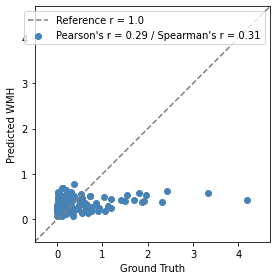

In [29]:
_,_ = predict(model, test_loader)

In [ ]:
net = SFCN()
net.load_state_dict(torch.load('pretrained/230131_sfcn+mae_best'))
net.to(device)
_,_ = predict(net, test_loader)

In [ ]:
dataset = NeckDataset(train_X, train_y)
data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=16)
_,_ = predict(model, train_loader, 'Training set')